In [1]:
library(dplyr)
library(ggplot2)
library(tidyverse)
library(broom)

options(repr.plot.width = 10, repr.plot.height = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
turnout_rating <- read.csv("../data/turnout_v_ratings.csv")
edu <- read.csv("../data/education.csv")

In [3]:
# make a function to select needed columns, rename them, and pivot them to rows
tidy_data <- function(data) {
    data %>%
    select(Rates, X1988, X1992, X1996, X2000, X2004, X2008, X2012, X2016) %>%
    rename("group" = Rates,"1988" = X1988,"1992" = X1992,"1996" = X1996,"2000" = X2000,"2004" = X2004,"2008" = X2008,"2012" = X2012,"2016" = X2016) %>%
    pivot_longer(!group, names_to = "election_year", values_to = "group_pct") %>%
    # Filter data to contain only rows describing the entire electorate
    filter(str_detect(group, "Share")) %>%
    # merge the data with the data about electoral turnout and competitiveness 
    merge(turnout_rating,by = "election_year")
}


merged_tidy_edu  <- tidy_data(edu) 

In [4]:
rank_data <- function(data) {
    data %>%
    group_by(election_year) %>%
    mutate(group_rank_per_election = rank(-group_pct)) %>%
    select(election_year, group, group_pct, group_rank_per_election, rating_std, turnout_scaled) %>%
    rename("competitiveness" = rating_std)
} 

ranked_edu <- rank_data(merged_tidy_edu)

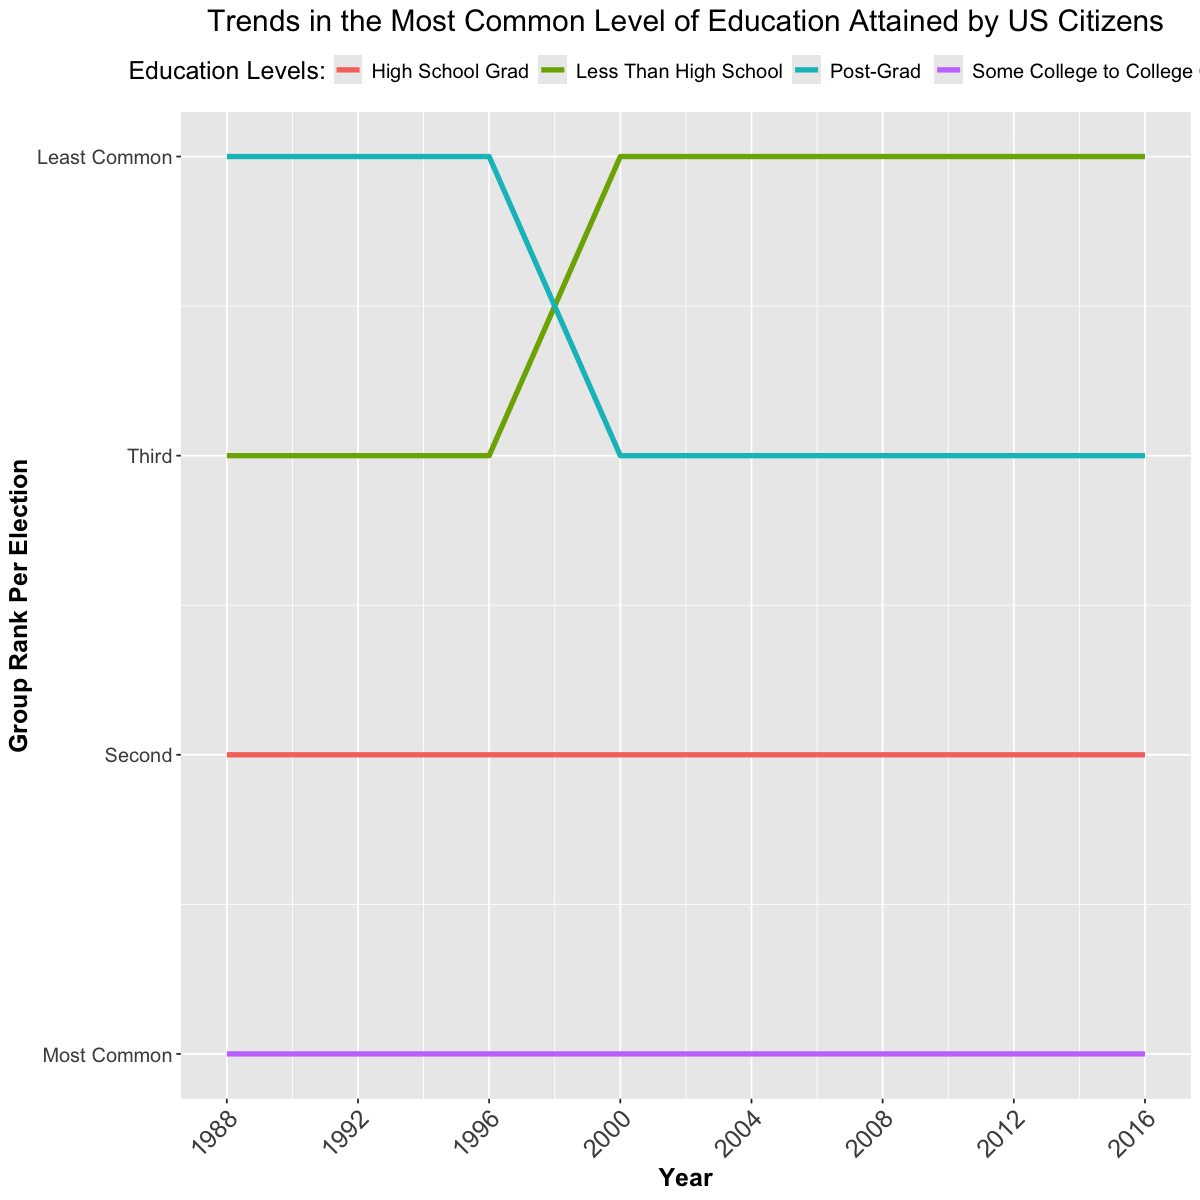

In [5]:
# Visualize changes in education groups over the years
ranked_edu$election_year <- as.numeric(ranked_edu$election_year)

# Plot changes in rankings
edu_trends <- ggplot(ranked_edu, aes(x = election_year, y = group_rank_per_election, color = group)) +
  geom_line(linewidth = 1.5) +
  labs(title = "Trends in the Most Common Level of Education Attained by US Citizens", x = "Year", y = "Group Rank Per Election", color = "Education Levels:") +
  scale_y_continuous(breaks = c(1, 2, 3, 4),  # Specify the y-axis ticks
                     labels = c("Most Common", "Second", "Third", "Least Common")) + # Specify the labels for the ticks
  scale_color_discrete(labels = c("High School Grad", "Less Than High School", "Post-Grad", "Some College to College Grad")) +
  theme(
    text = element_text(size = 15),
    axis.text.x = element_text(angle = 45, hjust = 1, size =15),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5),
    legend.position = "top",
    legend.justification = "centre"
  ) +
  scale_x_continuous(breaks = seq(1988, 2016, 4)) 

edu_trends

In [6]:
edu_model <- lm(competitiveness ~ turnout_scaled * group_pct, data=ranked_edu)
tidy(edu_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.993381e-01,0.220940733,3.165274686,0.003717295
turnout_scaled,-2.241637e-01,0.196106035,-1.143074088,0.262687603
group_pct,-1.873106e-05,0.007456140,-0.002512166,0.998013397
turnout_scaled:group_pct,1.107456e-05,0.006602984,0.001677205,0.998673677
